In [1]:
import sys
import numpy
import matplotlib
import skimage
import tensorflow as tf  
import cv2
from skimage.transform import resize, rescale 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from skimage import measure  
#import measure.compare_ssim as ssim
from skimage.metrics import structural_similarity as ssim
from matplotlib import pyplot as plt
import cv2
import numpy as np
import math
import os  
import matplotlib.pyplot as plt

2022-06-19 01:00:09.090013: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


# Load dataset low resolution

In [2]:
def train_low(path,size,scale):
    names = sorted(os.listdir(path)) # get  all items  in path
    print(len(names)) # print no. of img
    data = []
    for name in names:
        fpath = path + name  # add name  of img to the path
        img = cv2.imread(fpath, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (size,size),cv2.INTER_CUBIC)  # downsample bicubic
        img = cv2.resize(img, ((size*scale),(size*scale)),cv2.INTER_CUBIC) # make  upsamble bicubic to model 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb) 
        img = img[:, :, 0].astype(float) / 255   # y is the luma
        shape = img.shape
        data.append(img) 
    data = np.array(data) 
    return data

In [3]:
def train_high(path,size,scale):
    names = sorted(os.listdir(path))
    print(len(names))
    data = []
    for name in names:
        fpath = path + name
        img = cv2.imread(fpath, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (size,size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        img = img[:, :, 0].astype(float) / 255   # y is the luma.
        shape = img.shape
        data.append(img) # no. of images  #900 ---->(w,h)
    data = np.array(data)   # (no. of image, w, h) 
    return data

In [7]:
# define the SRCNN model
def model():
    
    # define model type
    SRCNN = Sequential()
    
    # add model layers  #    (1392, 2040, 3)
    SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True, input_shape=(None,None, 1)))
    SRCNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='same', use_bias=True))
    
    # define optimizer
    adam = Adam(lr=0.0003)
    
    # compile model
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['accuracy'])
    
    return SRCNN

In [8]:
srcnn = model()
srcnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, None, None, 128)   10496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 64)    73792     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 1)     1601      
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________


In [9]:
Xtrain_high =train_high('./data/train_data/DIV2K_train_HR/',256,2)

900


In [10]:
Xtrain_high.shape

(900, 256, 256)

In [13]:
y_train_low=train_low('./data/train_data/DIV2K_train_HR/',128,2)

900


In [14]:
y_train_low.shape

(900, 256, 256)

Text(0.5, 1.0, 'high resolution ')

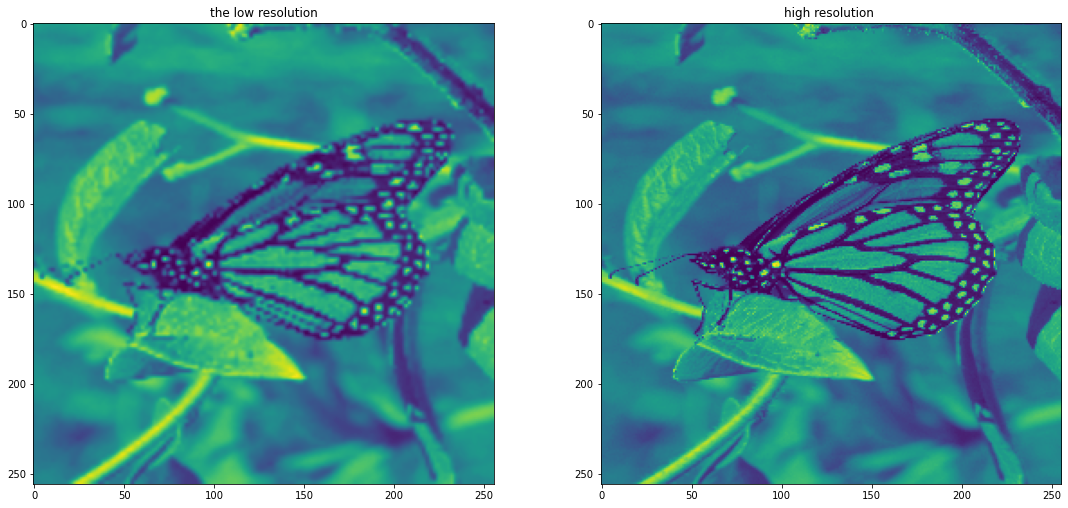

In [18]:
plt.figure(figsize = (100, 100))
i = 1
ax = plt.subplot(10, 10, i)
plt.imshow(y_train_low[5])
plt.title("the low resolution")
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(Xtrain_high[5])
plt.title("high resolution ")

In [19]:
low= numpy.zeros((y_train_low.shape[0], y_train_low.shape[1], y_train_low.shape[2], 1), dtype=float)
low[:, :, :, 0]=y_train_low[:, :, :].astype(float)
low.shape

(900, 256, 256, 1)

In [20]:
high= numpy.zeros((Xtrain_high.shape[0], Xtrain_high.shape[1], Xtrain_high.shape[2], 1), dtype=float)
high[:, :, :, 0]=Xtrain_high[:, :, :].astype(float)
high.shape

(900, 256, 256, 1)

In [22]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

In [23]:
history=srcnn.fit( low, high, batch_size=10, validation_split=0.2, shuffle=True, epochs=100,callbacks=[callback]) 

2022-06-19 01:16:25.241989: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-19 01:16:25.251253: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


Epoch 1/100


2022-06-19 01:16:25.635848: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-06-19 01:16:27.880582: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-06-19 01:16:27.956182: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-06-19 01:16:28.536051: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


72/72 [==============================] - 17s 105ms/step - loss: 0.0484 - accuracy: 0.0098 - val_loss: 0.0102 - val_accuracy: 0.0090
Epoch 2/100
72/72 [==============================] - 7s 102ms/step - loss: 0.0106 - accuracy: 0.0140 - val_loss: 0.0092 - val_accuracy: 0.0090
Epoch 3/100
72/72 [==============================] - 7s 103ms/step - loss: 0.0095 - accuracy: 0.0111 - val_loss: 0.0090 - val_accuracy: 0.0090
Epoch 4/100
72/72 [==============================] - 7s 103ms/step - loss: 0.0095 - accuracy: 0.0104 - val_loss: 0.0089 - val_accuracy: 0.0090
Epoch 5/100
72/72 [==============================] - 7s 104ms/step - loss: 0.0099 - accuracy: 0.0111 - val_loss: 0.0089 - val_accuracy: 0.0090
Epoch 6/100
72/72 [==============================] - 7s 104ms/step - loss: 0.0095 - accuracy: 0.0118 - val_loss: 0.0089 - val_accuracy: 0.0090
Epoch 7/100
72/72 [==============================] - 8s 104ms/step - loss: 0.0093 - accuracy: 0.0136 - val_loss: 0.0088 - val_accuracy: 0.0090
Epoch 8/10

72/72 [==============================] - 8s 110ms/step - loss: 0.0091 - accuracy: 0.0103 - val_loss: 0.0085 - val_accuracy: 0.0090
Epoch 59/100
72/72 [==============================] - 8s 110ms/step - loss: 0.0090 - accuracy: 0.0105 - val_loss: 0.0086 - val_accuracy: 0.0090
Epoch 60/100
72/72 [==============================] - 8s 110ms/step - loss: 0.0093 - accuracy: 0.0119 - val_loss: 0.0085 - val_accuracy: 0.0090
Epoch 61/100
72/72 [==============================] - 8s 110ms/step - loss: 0.0090 - accuracy: 0.0092 - val_loss: 0.0085 - val_accuracy: 0.0090
Epoch 62/100
72/72 [==============================] - 8s 110ms/step - loss: 0.0089 - accuracy: 0.0139 - val_loss: 0.0086 - val_accuracy: 0.0090
Epoch 63/100
72/72 [==============================] - 8s 110ms/step - loss: 0.0089 - accuracy: 0.0088 - val_loss: 0.0085 - val_accuracy: 0.0090
Epoch 64/100
72/72 [==============================] - 8s 110ms/step - loss: 0.0090 - accuracy: 0.0111 - val_loss: 0.0085 - val_accuracy: 0.0090
Epoch

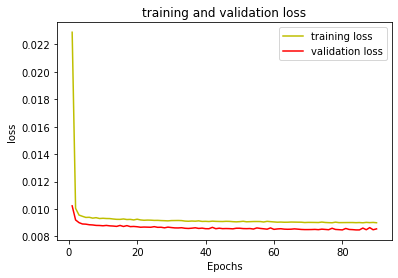

In [24]:
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,'y',label="training loss")
plt.plot(epochs,val_loss,'r',label="validation loss")
plt.title("training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

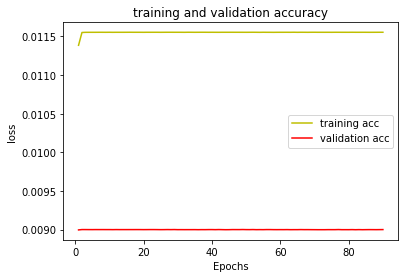

In [25]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
epochs=range(1,len(loss)+1)
plt.plot(epochs,acc,'y',label="training acc")
plt.plot(epochs,val_acc,'r',label="validation acc")
plt.title("training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [26]:
srcnn.save('srcnn_model_2x.h5')
